### Import

In [1]:
import numpy as np
import base64
import struct
from cobs import cobs
from collections import namedtuple
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from tqdm.notebook import tqdm
import scipy.signal
import scipy.io
import rawpy
import imageio
import time
import os
import seaborn as sns

In [2]:
name_animal= 'A02_Gaudi'
Path ='/home/morgane/Documents/'+name_animal+'/'
Files='20221122-140903_278_decoded.mat'
date='20221011'
data=os.path.join(Path, Files)
#data='/home/morgane/Documents/A02_Gaudi/20221110-135651_237_decoded.mat'
packet = scipy.io.loadmat(data)

prepare data

In [3]:
analog=packet['analog']
states=packet['longVar']
digitalIn=packet['digitalIn']
digitalOut=packet['digitalOut']
long=packet['packetNums']
num_packet=len(long[0])
time=num_packet/1000/60
digitalIn[:,6]=1-digitalIn[:,6]

### Figure

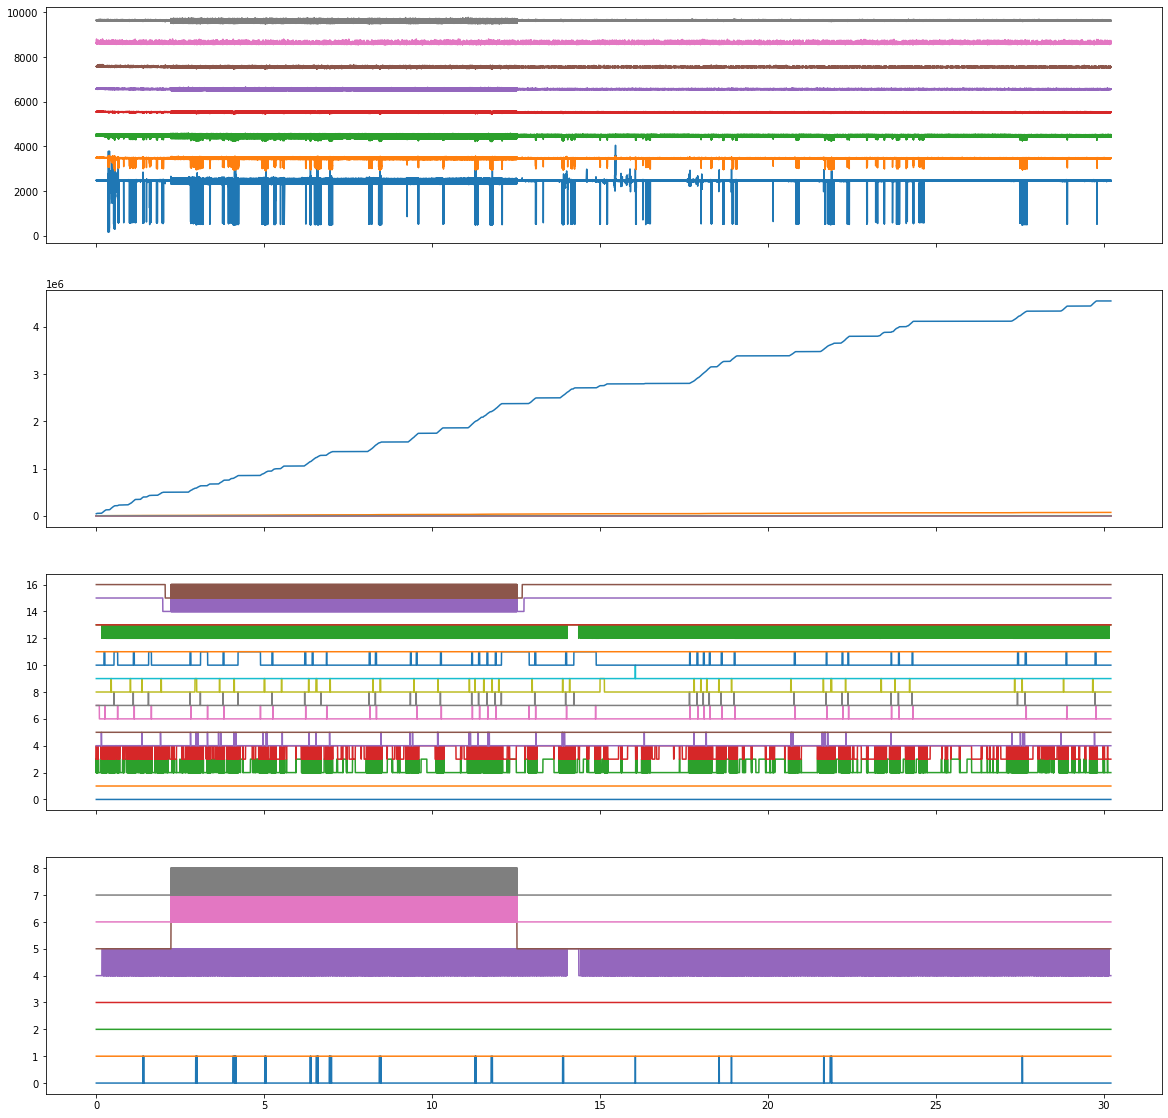

In [4]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True)
t = np.linspace(0,time,num_packet)
for n in range(8):
    ax[0].plot(t,analog[:, n]+n*1024)
    ax[1].plot(t,states[:, n])
    ax[3].plot(t,digitalOut[:, n]+n)

for n in range(16):
        ax[2].plot(t,digitalIn[:, n]+n)

Lick detection

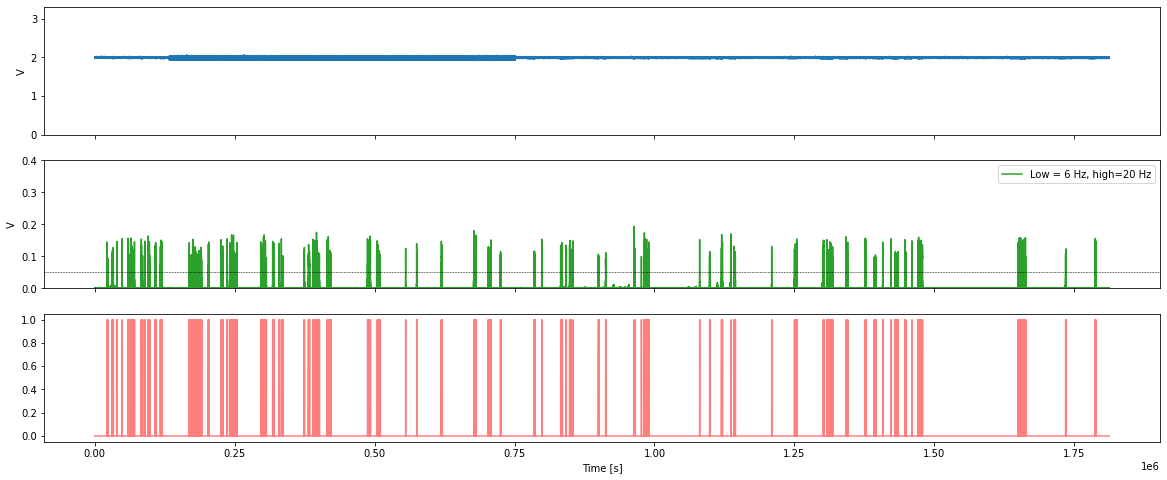

In [5]:
#Clean analog channel
fs = 1000

start, end = 17*fs, 60*fs

lo, hi = 6, 20
b, a = scipy.signal.butter(3, [2*lo/fs, 2*hi/fs], 'band')
uVolt = 3.3/4096

threshold = 0.05
new_analog=[]
filtered = np.abs(scipy.signal.filtfilt(b, a, analog[:, 1]))*uVolt

fig, ax = plt.subplots(3, figsize=(20, 8), sharex=True)
ax[0].plot( analog[:, 4]*uVolt, c=f'C{0}')
ax[0].set_ylim(0, 3.3)
ax[0].set_ylabel('V')
ax[1].plot( filtered, c=f'C{2}', alpha=1, label=f'Low = {lo} Hz, high={hi} Hz')

ax[1].set_ylim(0, 0.400)
ax[1].axhline(threshold, c='k', linestyle='--', linewidth=0.5)
ax[1].set_ylabel('V')
ax[1].legend()
ax[2].plot(filtered >threshold, c='r', alpha=0.5)
ax[2].set_xlabel('Time [s]');

In [6]:
lick=np.zeros(num_packet,dtype=int)
for i in range(0,num_packet):
    if filtered[i]>threshold:
        lick[i]=1

In [28]:
trial=[]
tunnel=[]
j=0
k=0
timestamp1=0
timestamp2=0
initial1=0
initial2=0
len1=0
len2=0
for i in range(0,num_packet):
    if (digitalIn[i,10]==0):
        timestamp1+=1
        if (len(states[initial2:(initial2+timestamp2),1])!=0):
            tunnel.append(states[initial2:(initial2+timestamp2),1])
        initial2=i
        timestamp2=0
    elif (digitalIn[i,10]==1):
        if (len(states[initial1:(initial1+timestamp1),1])!=0):
            trial.append(states[initial1:(initial1+timestamp1),1])
        initial1=i
        timestamp2+=1
        timestamp1=0

In [30]:
lick_trial=[]
lick_tunnel=[]
j=0
k=0
timestamp1=0
timestamp2=0
initial1=0
initial2=0
len1=0
len2=0
for i in range(0,num_packet):
    if (digitalIn[i,10]==0):
        timestamp1+=1
        if (len(lick[initial2:(initial2+timestamp2)])!=0):
            lick_tunnel.append(lick[initial2:(initial2+timestamp2)])
        initial2=i
        timestamp2=0
    elif (digitalIn[i,10]==1):
        if (len(lick[initial1:(initial1+timestamp1)])!=0):
            lick_trial.append(lick[initial1:(initial1+timestamp1)])
        
        initial1=i
        timestamp2+=1
        timestamp1=0

In [32]:
reward_area=[]
j=0
k=0
timestamp1=0
timestamp2=0
initial1=0
initial2=0
len1=0
len2=0
for i in range(0,num_packet):
    if (digitalIn[i,10]==0):
        timestamp1+=1
        initial2=i
        timestamp2=0
    elif (digitalIn[i,10]==1):
        if (len(digitalIn[initial1:(initial1+timestamp1),8])!=0):
            reward_area.append(digitalIn[initial1:(initial1+timestamp1),8])
        initial1=i
        timestamp2+=1
        timestamp1=0

In [34]:
reward=[]
j=0
k=0
timestamp1=0
timestamp2=0
initial1=0
initial2=0
len1=0
len2=0
for i in range(0,num_packet):
    if (digitalIn[i,10]==0):
        timestamp1+=1
        initial2=i
        timestamp2=0
    elif (digitalIn[i,10]==1):
        if (len(digitalOut[initial1:(initial1+timestamp1),0])!=0):
            reward.append(digitalOut[initial1:(initial1+timestamp1),0])  
        initial1=i
        timestamp2+=1
        timestamp1=0

In [35]:
cue=[]
j=0
k=0
timestamp1=0
timestamp2=0
initial1=0
initial2=0
len1=0
len2=0
for i in range(0,num_packet):
    if (digitalIn[i,10]==0):
        timestamp1+=1
        initial2=i
        timestamp2=0
    elif (digitalIn[i,10]==1):
        if (len(digitalIn[initial1:(initial1+timestamp1),13])!=0):
            cue.append(digitalIn[initial1:(initial1+timestamp1),13]) 
        initial1=i
        timestamp2+=1
        timestamp1=0

In [36]:
spot=[]
j=0
k=0
timestamp1=0
timestamp2=0
initial1=0
initial2=0
len1=0
len2=0
for i in range(0,num_packet):
    if (digitalIn[i,10]==0):
        timestamp1+=1
        initial2=i
        timestamp2=0
    elif (digitalIn[i,10]==1):
        if (len(digitalIn[initial1:(initial1+timestamp1),1])!=0):
            spot.append(digitalIn[initial1:(initial1+timestamp1),1])
        initial1=i
        timestamp2+=1
        timestamp1=0

reward area and lick per trial

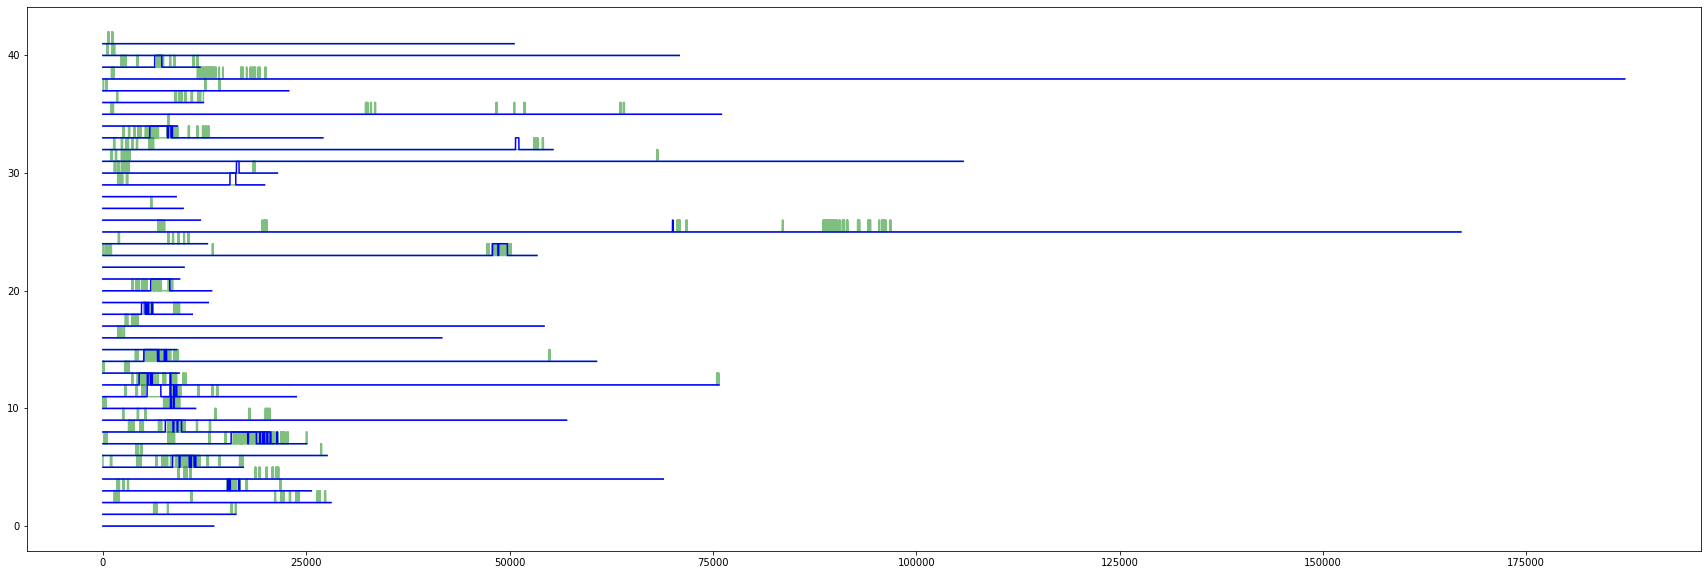

In [37]:
plt.subplots(figsize=(30, 10), sharex=True)
for i in range(0,len(trial)):
    plt.plot(lick_trial[i]+i,'g',alpha=0.5)
    plt.plot(reward[i]+i,'b')
    #plt.plot(reward_area[i]+i,'black')
    #plt.plot(spot[i]+i,'r')
    #plt.plot(cue[i]+i,'r')

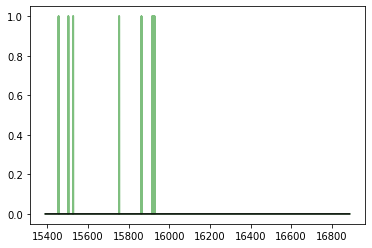

In [38]:
t=np.linspace(min(trial[9]),max(trial[9]),len(trial[9]))
plt.plot(t,lick_trial[9],'g',alpha=0.5)
    #plt.plot(reward[i]+i,'b')
plt.plot(t,reward[9],'black')


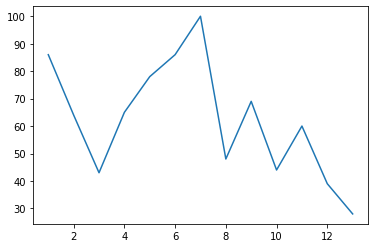

In [1382]:
days=[1,2,3,4,5,6,7,8,9,10,11,12,13]
success=[86,64,43,65,78,86,100,48,69,44,60,39,28]
plot(days,success)

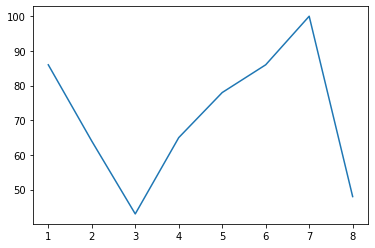

In [1383]:
days=[1,2,3,4,5,6,7,8]
success=[86,64,43,65,78,86,100,48]
plot(days,success)

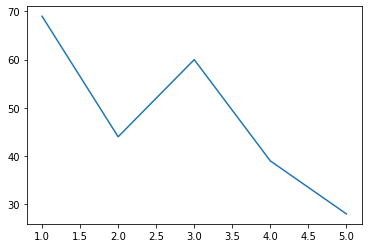

In [1384]:

days=[1,2,3,4,520221110-135651_237_decoded]
success=[69,44,60,39,28]
plot(days,success)

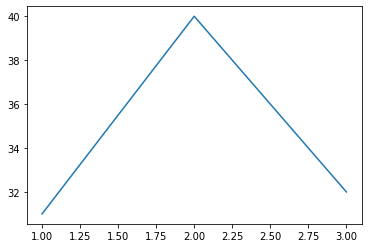

In [1380]:
days=[1,2,3]
success=[31,40,32]
plot(days,success)

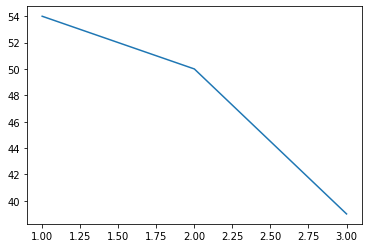

In [1381]:
days=[1,2,3]
success=[54,50,39]
plot(days,success)

In [ ]:
plt.subplots(figsize=(20, 10))
for i in range(0,len(Timestamp2)-1):
    f=states[Timestamp2[i]:Timestamp2[i+1],1]
    l=states[Timestamp2[i]:Timestamp2[i+1],3]
    idx2 = np.argwhere(np.diff(np.sign(l))).flatten()
    t = np.arange(Timestamp2[i],Timestamp2[i+1])
    plt.plot(t,f, 'r')
    plt.plot(t[idx2],f[idx2],'bo')
    plt.ylabel('Distance (mm)')
    #plt.title(name_animal+'_'+date +'_Tunnels_licks')
#plt.savefig(name_animal+'_'+date+'_Tunnels_licks.png')

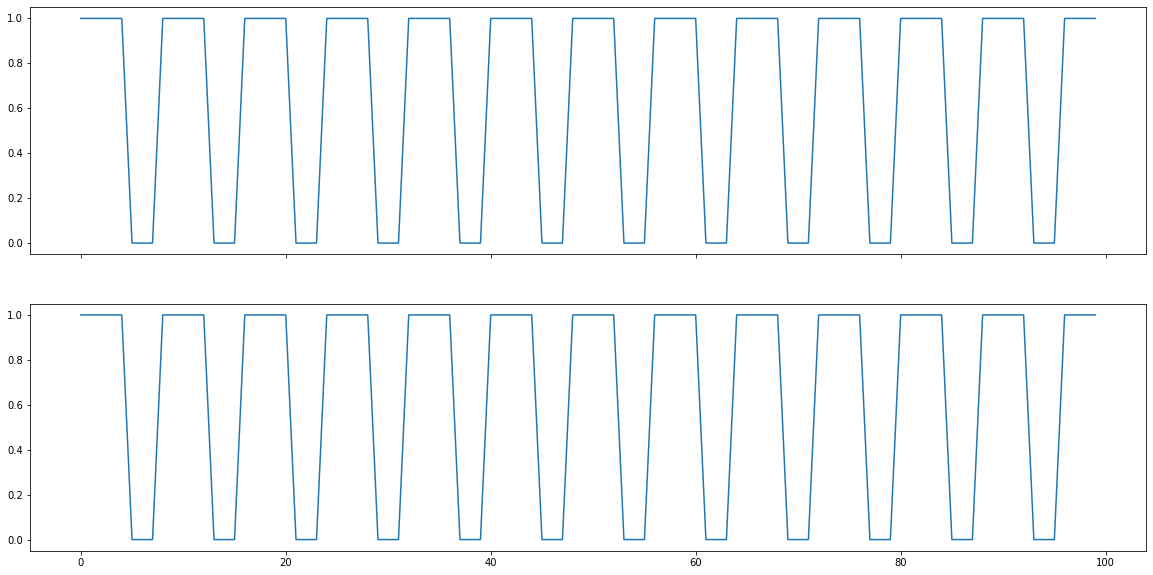

In [46]:
fig, ax = plt.subplots(2,figsize=(20, 10), sharex=True)
ax[0].plot(digitalIn[450000:450100,14])
ax[1].plot(digitalOut[450000:450100,7])

In [54]:
test=digitalIn[450000:450100,14]-digitalOut[450000:450100,7]

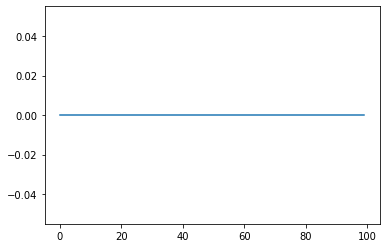

In [55]:
plot(test)